### Packages

In [9]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(style='darkgrid', font_scale=1.4)
import time


from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

### Kaggle dataset downloading

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/programming/kaggle/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
! kaggle competitions download -c spaceship-titanic

  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 43.6MB/s]


In [13]:
! ls

drive  sample_data  spaceship-titanic.zip


In [14]:
! unzip spaceship-titanic.zip

Archive:  spaceship-titanic.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


### Data 

In [15]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [16]:
df_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


### EDA

Let's check class distribution in the training dataset.

In [17]:
class_ratio = df_train['Transported'].value_counts() / len(df_train['Transported'])
class_ratio

True     0.503624
False    0.496376
Name: Transported, dtype: float64

Text(0.5, 1.0, 'Target distribution')

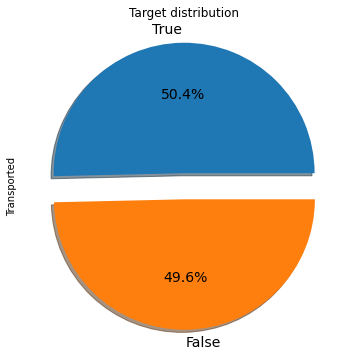

In [18]:
plt.figure(figsize=(6,6))
df_train['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':14}).set_title("Target distribution")

Classes are evenly distributed.

In [19]:
train_miss_values = df_train.isna().sum()
test_miss_values = df_test.isna().sum()

train_miss_values_ratio = round(train_miss_values / len(df_train), 3)*100
test_miss_values_ratio = round(test_miss_values / len(df_test), 3)*100

pd.concat([train_miss_values.rename('train set missing values'), train_miss_values_ratio.rename('percent_train'),  test_miss_values.rename('test set missing values'), test_miss_values_ratio.rename('percent_test')], axis=1)

,train set missing values,percent_train,test set missing values,percent_test
PassengerId,0,0.0,0.0,0.0
HomePlanet,201,2.3,87.0,2.0
CryoSleep,217,2.5,93.0,2.2
Cabin,199,2.3,100.0,2.3
Destination,182,2.1,92.0,2.2
Age,179,2.1,91.0,2.1
VIP,203,2.3,93.0,2.2
RoomService,181,2.1,82.0,1.9
FoodCourt,183,2.1,106.0,2.5
ShoppingMall,208,2.4,98.0,2.3


Text(0.5, 1.0, 'Heatmap of missing values')

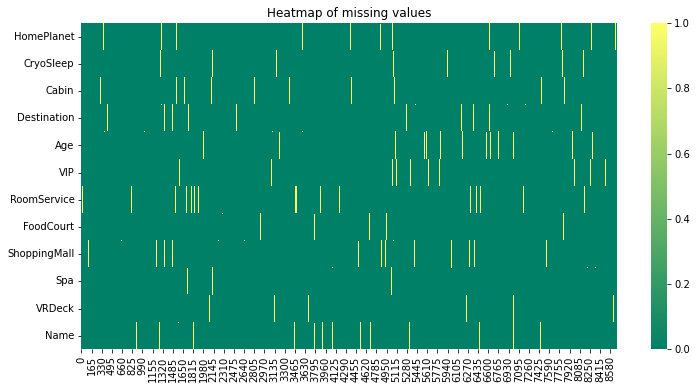

In [20]:
na_cols=df_train.columns[df_train.isna().any()].tolist()
plt.figure(figsize=(12,6))
sns.heatmap(df_train[na_cols].isna().T, cmap='summer')
plt.title('Heatmap of missing values')

In [21]:
print('% of passengers with at least one missing value: ', round(df_train.isna().any(axis=1).sum() / len(df_train)*100, 2))

% of passengers with at least one missing value:  24.01


In [22]:
print(f'Duplicates in train set: {df_train.duplicated().sum()}, ({np.round(100*df_train.duplicated().sum()/len(df_train),1)}%)')
print(f'Duplicates in test set: {df_test.duplicated().sum()}, ({np.round(100*df_test.duplicated().sum()/len(df_test),1)}%)')

Duplicates in train set: 0, (0.0%)
Duplicates in test set: 0, (0.0%)


All features (excepting PassengerID) have missing values of less than 3%. Simple data imputation can be implement to improve the dataset quality. 

In [23]:
pd.concat([df_train.nunique().rename('unique values'), df_train.dtypes.rename('type')], axis=1)

,unique values,type
PassengerId,8693,object
HomePlanet,3,object
CryoSleep,2,object
Cabin,6560,object
Destination,3,object
Age,80,float64
VIP,2,object
RoomService,1273,float64
FoodCourt,1507,float64
ShoppingMall,1115,float64


There are 6 continuous features (Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck), 2 boolean features (CryoSleep, VIP), 5 descriptive/categorical features (PassengerID, HomePlanet, Cabin, Destination, Name). 

First, let's visualize continuous features. 

In [24]:
cont_features = [f for f in df_train.columns if (df_train[f].dtype == float)]
cont_features

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

Text(0.5, 1.0, 'Age class ratio (TRAIN)')

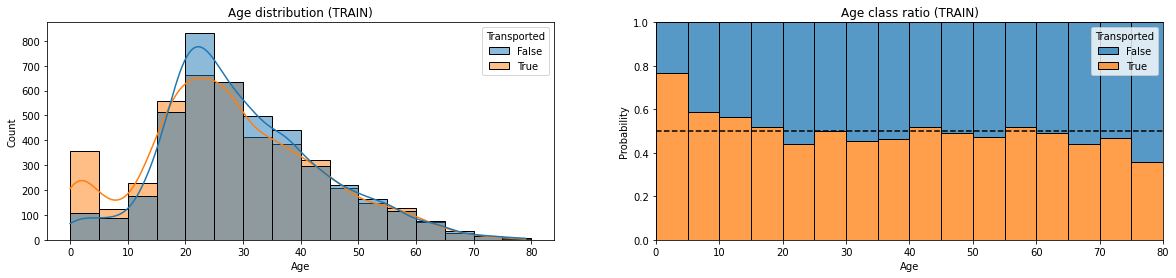

In [25]:
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,1)
    sns.histplot(data=df_train, x='Age', hue='Transported', binwidth = 5, kde=True)
    plt.title('Age distribution (TRAIN)')

    plt.subplot(1,2,2)
    sns.histplot(data=df_train, x='Age', hue='Transported', stat = "probability", binwidth = 5, multiple="fill")
    plt.axhline(0.5,color='black', linestyle='--')
    plt.title('Age class ratio (TRAIN)')

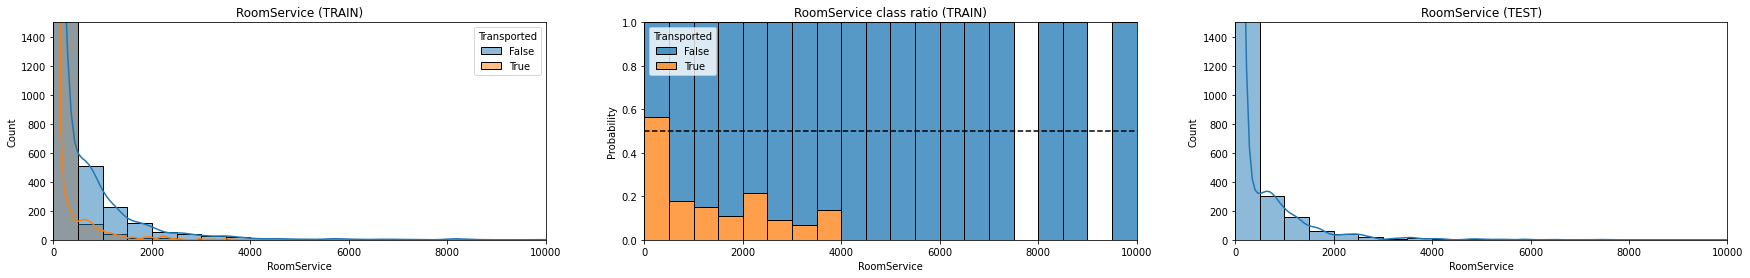

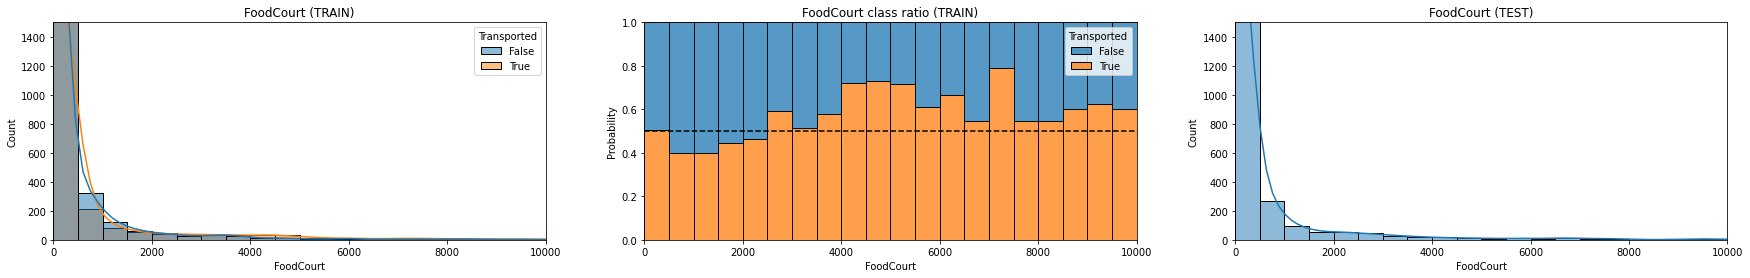

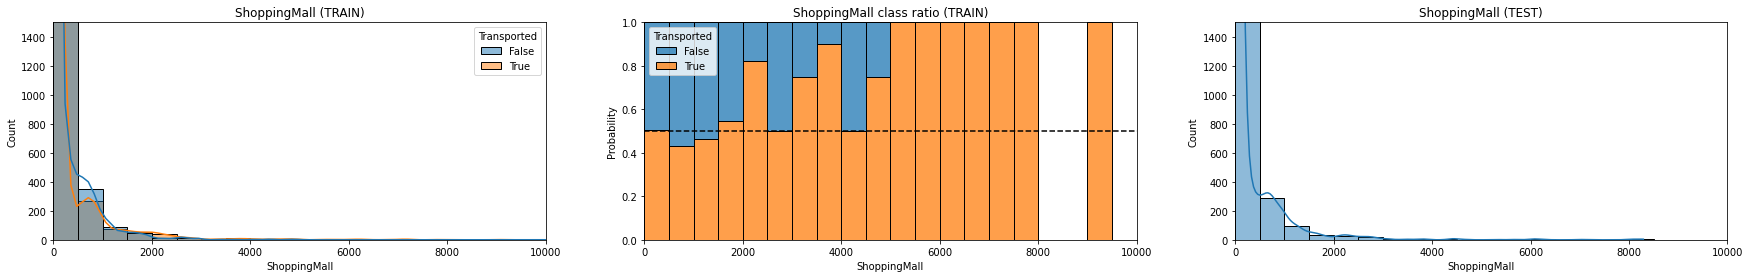

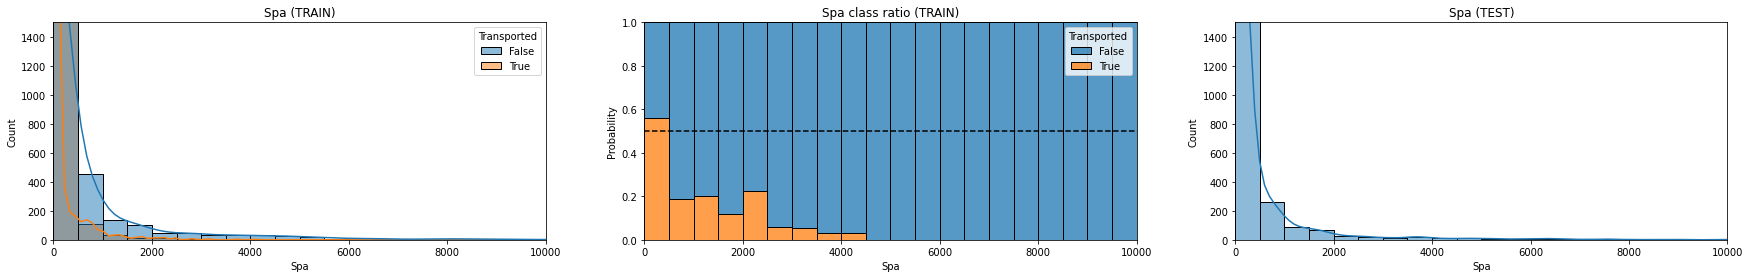

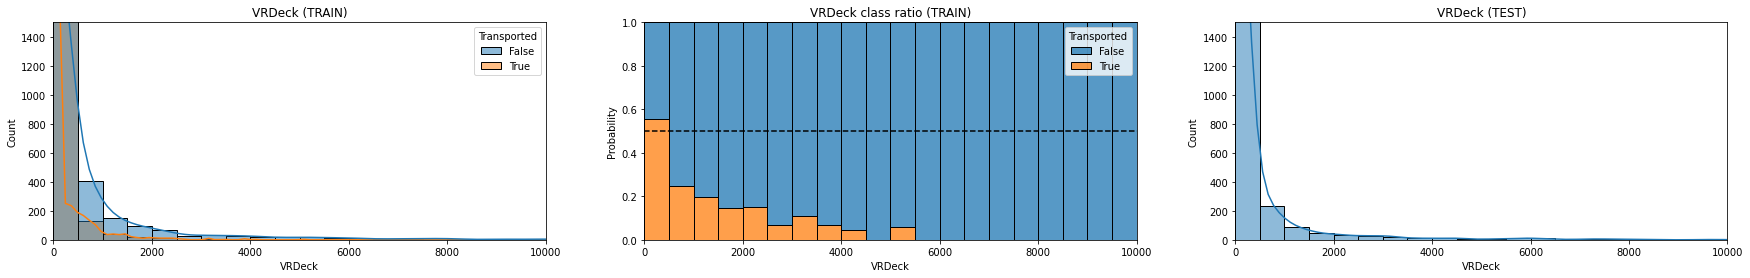

In [26]:
for feature in cont_features:
    if feature == 'Age':
      continue
    
    plt.figure(figsize=(30,4))
    plt.subplot(1,3,1)
    plt.ylim([0,1500])
    plt.xlim([0,10000])
    sns.histplot(data=df_train, x=feature, hue='Transported', kde=True, binwidth = 500)
    plt.title(feature+' (TRAIN)')

    plt.subplot(1,3,2)
    sns.histplot(data=df_train, x=feature, hue='Transported', stat = "probability", binwidth = 500, multiple="fill")
    plt.xlim([0,10000])
    plt.axhline(0.5,color='black', linestyle='--')
    plt.title(feature+' class ratio (TRAIN)')


    plt.subplot(1,3,3)
    plt.ylim([0,1500])
    plt.xlim([0,10000])
    sns.histplot(data=df_test, x=feature, kde=True, binwidth = 500)
    plt.title(feature+' (TEST)')

    plt.show()

Most people spent little or no money. Ratio of transported people varies with rasing spendings and depends on the spending category. Let's see how it looks like on total spendings. 

In [27]:
spendings_features = [x for x in cont_features if x != "Age"]

df_train['total_spendings'] = df_train[spendings_features].sum(axis=1)
df_test['total_spendings'] = df_test[spendings_features].sum(axis=1)

In [28]:
df_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,total_spendings
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,8536.0
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,0.0
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,1873.0
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,4637.0


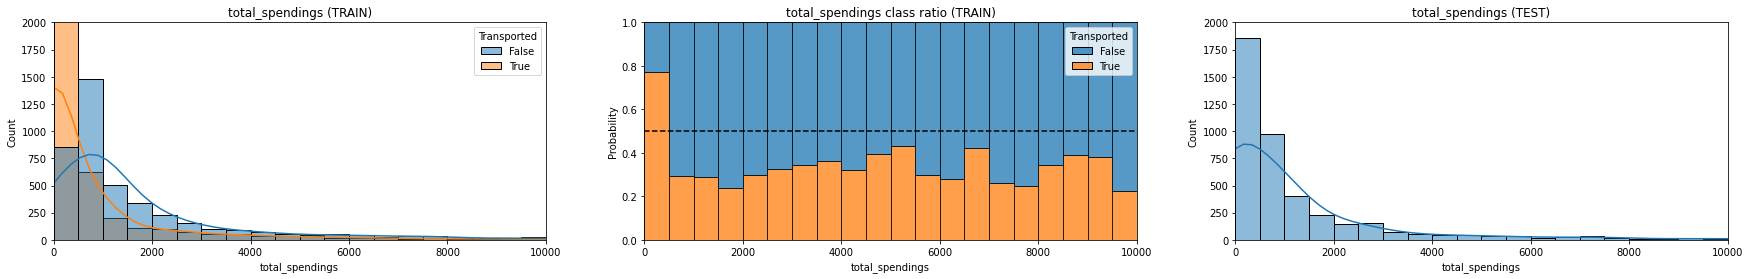

In [29]:
plt.figure(figsize=(30,4))
plt.subplot(1,3,1)
plt.ylim([0,2000])
plt.xlim([0,10000])
sns.histplot(data=df_train, x='total_spendings', hue='Transported', kde=True, binwidth = 500)
plt.title('total_spendings'+' (TRAIN)')

plt.subplot(1,3,2)
sns.histplot(data=df_train, x='total_spendings', hue='Transported', stat = "probability", binwidth = 500, multiple="fill")
plt.xlim([0,10000])
plt.axhline(0.5,color='black', linestyle='--')
plt.title('total_spendings'+' class ratio (TRAIN)')


plt.subplot(1,3,3)
plt.ylim([0,2000])
plt.xlim([0,10000])
sns.histplot(data=df_test, x='total_spendings', kde=True, binwidth = 500)
plt.title('total_spendings'+' (TEST)')

plt.show()

It might be interesting to add a feature that indicates whether the passenger had any expenses. It will be boolean feature: 0 - if passenger had no expenses, 1 if passenger had any expenses.

In [30]:
def if_spendings(row):
  if row['total_spendings'] == 0.0:
    return 0
  else:
    return 1

df_train['if_spendings'] = df_train.apply(lambda row: if_spendings(row), axis=1)
df_test['if_spendings'] = df_test.apply(lambda row: if_spendings(row), axis=1)

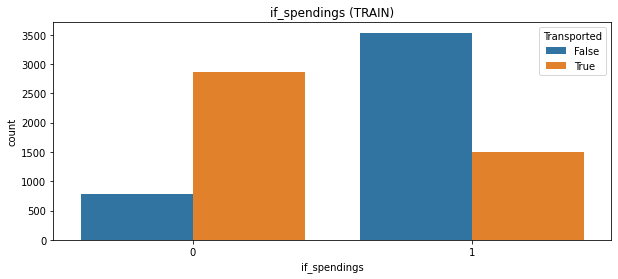

In [31]:
plt.figure(figsize=(22,4))
plt.subplot(1,2,1)
sns.countplot(data=df_train, x='if_spendings', hue='Transported')
plt.title('if_spendings'+' (TRAIN)')
plt.show()

In [32]:
print('Zero to non-zero expenses ratio (TRAIN): ')
print(df_train['if_spendings'].value_counts() / len(df_train))
print(' ')
print('Zero to non-zero expenses ratio (TEST): ')
print(df_test['if_spendings'].value_counts() / len(df_test))

Zero to non-zero expenses ratio (TRAIN): 
1    0.579777
0    0.420223
Name: if_spendings, dtype: float64
 
Zero to non-zero expenses ratio (TEST): 
1    0.578209
0    0.421791
Name: if_spendings, dtype: float64


It is now clear that those who had no expenses were much less likely not to be transported. 

Now let's take a look on some boolean and categorical features. 

In [33]:
cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

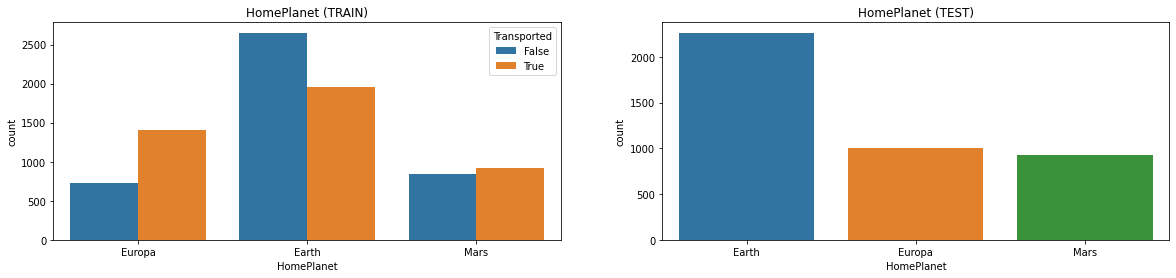

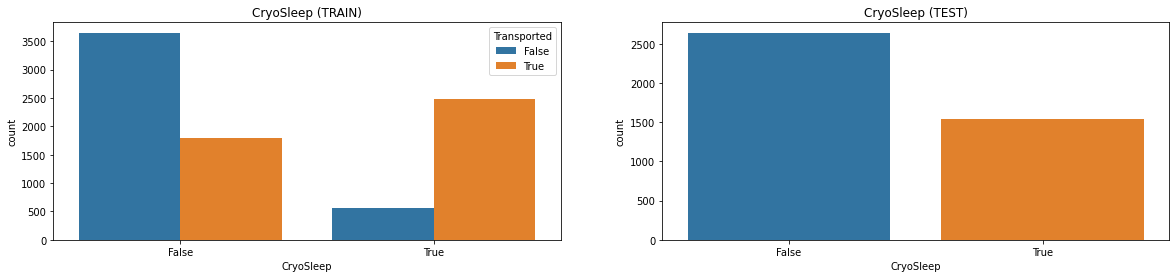

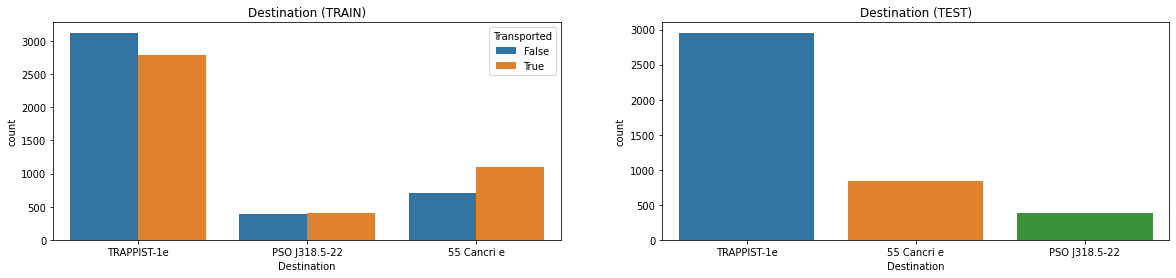

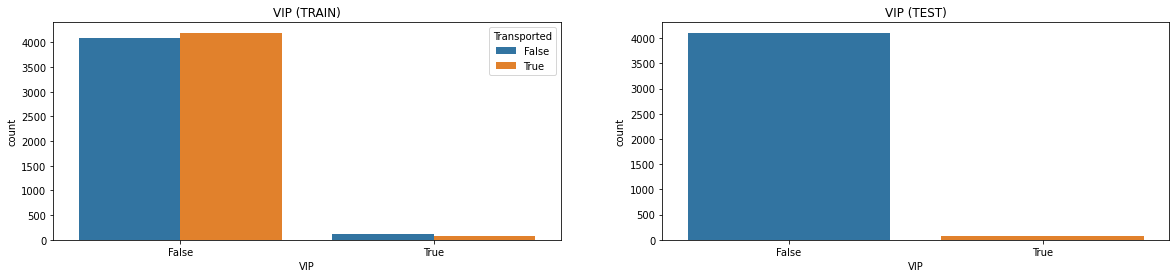

In [34]:
for feature in cat_features:
    
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,1)
    sns.countplot(data=df_train, x=feature, hue='Transported')
    plt.title(feature+' (TRAIN)')

    plt.subplot(1,2,2)
    sns.countplot(data=df_test, x=feature)
    plt.title(feature+' (TEST)')

    plt.show()

The VIP function does not look helpful, since the distribution of target classes is more or less equal in both categories, while CryoSleep feature can be very useful feature in training.

Only 3 features are left: PassengerId, Cabin and Name. PassengerId doesn't look useful since it is only numerical order of all passengers, but we can split Cabin feature into 3 features indicating deck, number and side as it is said in data description:

`Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.` 

and check its usability.

In [35]:
cabin = df_train["Cabin"].str.split("/", expand = True)
cabin.columns = ['deck', 'cabin_number', 'side']
df_train = pd.concat([df_train, cabin], axis = 1)
df_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,total_spendings,if_spendings,deck,cabin_number,side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,0,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0,1,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0,1,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0,1,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0,1,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,8536.0,1,A,98,P
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,0.0,0,G,1499,S
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,1873.0,1,G,1500,S
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,4637.0,1,E,608,S


In [36]:
cabin = df_test["Cabin"].str.split("/", expand = True)
cabin.columns = ['deck', 'cabin_number', 'side']
df_test = pd.concat([df_test, cabin], axis = 1)

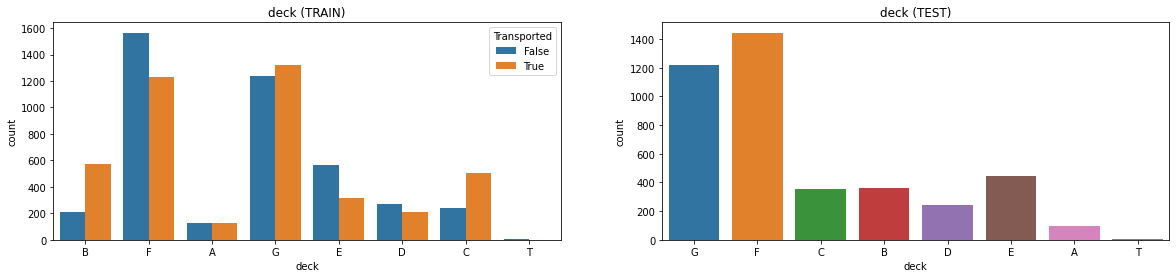

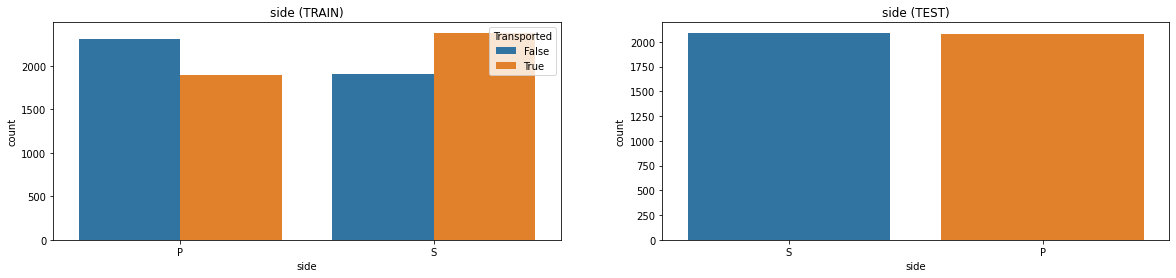

In [37]:
for feature in cabin.columns:
    if feature == 'cabin_number':
      continue

    plt.figure(figsize=(20,4))
    plt.subplot(1,2,1)
    sns.countplot(data=df_train, x=feature, hue='Transported')
    plt.title(feature+' (TRAIN)')

    plt.subplot(1,2,2)
    sns.countplot(data=df_test, x=feature)
    plt.title(feature+' (TEST)')

    plt.show()

In [38]:
df_train['cabin_number'] = pd.to_numeric(df_train['cabin_number'], errors='coerce')
df_test['cabin_number'] = pd.to_numeric(df_test['cabin_number'], errors='coerce')

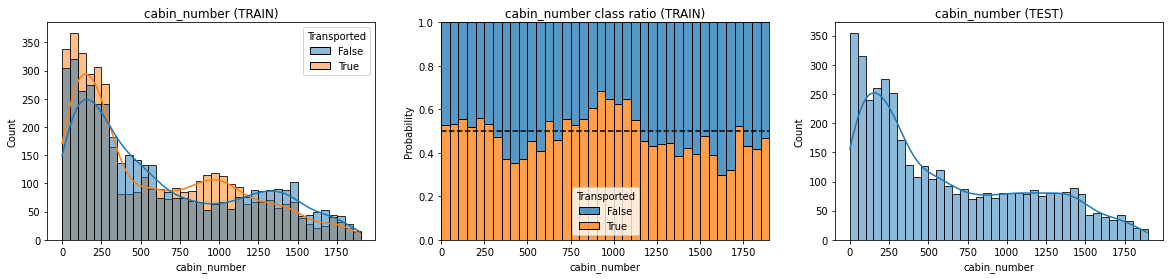

In [40]:
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
sns.histplot(data=df_train, x='cabin_number', hue='Transported', binwidth = 50, kde = True)
plt.title('cabin_number'+' (TRAIN)')

plt.subplot(1,3,2)
sns.histplot(data=df_train, x='cabin_number', hue='Transported', stat = "probability", binwidth = 50, multiple="fill")
plt.axhline(0.5,color='black', linestyle='--')
plt.title('cabin_number'+' class ratio (TRAIN)')

plt.subplot(1,3,3)
sns.histplot(data=df_test, x='cabin_number', binwidth = 50, kde = True)
plt.title('cabin_number'+' (TEST)')

plt.show()

As it can be seen, all cabin informations can be useful during model training.

In [41]:
pax_id = df_train["PassengerId"].str.split("_", expand = True)
pax_id.columns = ['group', 'id']
df_train = pd.concat([df_train, pax_id], axis = 1)

pax_id = df_test["PassengerId"].str.split("_", expand = True)
pax_id.columns = ['group', 'id']
df_test = pd.concat([df_test, pax_id], axis = 1)

In [42]:
df_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,total_spendings,if_spendings,deck,cabin_number,side,group,id
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Maham Ofracculy,False,0.0,0,B,0.0,P,0001,01
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,44.0,Juanna Vines,True,736.0,1,F,0.0,S,0002,01
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,49.0,Altark Susent,False,10383.0,1,A,0.0,S,0003,01
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,193.0,Solam Susent,False,5176.0,1,A,0.0,S,0003,02
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,2.0,Willy Santantines,True,1091.0,1,F,1.0,S,0004,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,...,74.0,Gravior Noxnuther,False,8536.0,1,A,98.0,P,9276,01
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,...,0.0,Kurta Mondalley,False,0.0,0,G,1499.0,S,9278,01
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,...,0.0,Fayey Connon,True,1873.0,1,G,1500.0,S,9279,01
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,...,3235.0,Celeon Hontichre,False,4637.0,1,E,608.0,S,9280,01


In [43]:
df_train['group'] = pd.to_numeric(df_train['group'], errors='coerce')
df_test['group'] = pd.to_numeric(df_test['group'], errors='coerce')

df_train['id'] = pd.to_numeric(df_train['id'], errors='coerce')
df_test['id'] = pd.to_numeric(df_test['id'], errors='coerce')

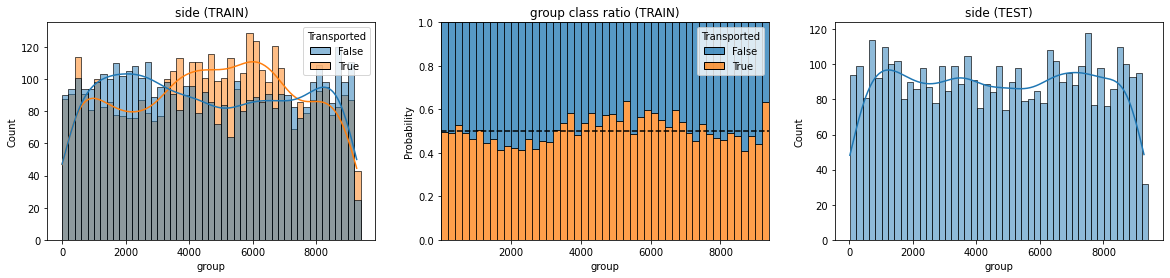

In [44]:
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
sns.histplot(data=df_train, x='group', hue='Transported', binwidth = 200, kde = True)
plt.title('group (TRAIN)')

plt.subplot(1,3,2)
sns.histplot(data=df_train, x='group', hue='Transported', stat = "probability", binwidth = 200, multiple="fill")
plt.axhline(0.5,color='black', linestyle='--')
plt.title('group'+' class ratio (TRAIN)')

plt.subplot(1,3,3)
sns.histplot(data=df_test, x='group', binwidth = 200, kde = True)
plt.title('group (TEST)')

plt.show()

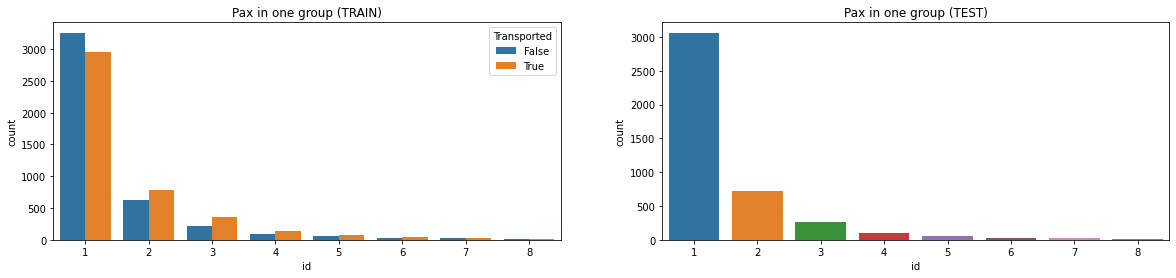

In [45]:
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.countplot(data=df_train, x='id', hue='Transported')
plt.title('Pax in one group (TRAIN)')

plt.subplot(1,2,2)
sns.countplot(data=df_test, x='id')
plt.title('Pax in one group (TEST)')

plt.show()

### Missing values

The easiest way to impute missing values is to use median for continous features and mode (the most frequent value) for categorical features. Another way to impute continous missing values is to use KNNImputer (or any other imputer), which try to impute missing values based on k-nearest neigbourhood. 

In [46]:
df_train['Age'].fillna(df_train['Age'].median(), inplace=True)
df_test['Age'].fillna(df_train['Age'].median(), inplace=True)

In [47]:
df_train['HomePlanet'].fillna(df_train['HomePlanet'].mode().item(), inplace=True)
df_test['HomePlanet'].fillna(df_train['HomePlanet'].mode().item(), inplace=True)

df_train['CryoSleep'].fillna(df_train['CryoSleep'].mode().item(), inplace=True)
df_test['CryoSleep'].fillna(df_train['CryoSleep'].mode().item(), inplace=True)

df_train['Destination'].fillna(df_train['Destination'].mode().item(), inplace=True)
df_test['Destination'].fillna(df_train['Destination'].mode().item(), inplace=True)

df_train['VIP'].fillna(df_train['VIP'].mode().item(), inplace=True)
df_test['VIP'].fillna(df_train['VIP'].mode().item(), inplace=True)

df_train['deck'].fillna(df_train['deck'].mode().item(), inplace=True)
df_test['deck'].fillna(df_train['deck'].mode().item(), inplace=True)

df_train['side'].fillna(df_train['side'].mode().item(), inplace=True)
df_test['side'].fillna(df_train['side'].mode().item(), inplace=True)

In [48]:
cont_features

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [49]:
imputer = KNNImputer(n_neighbors=3)
for feature in cont_features:
  df_train[feature] = imputer.fit_transform(np.array(df_train[feature]).reshape(-1,1))
  df_test[feature] = imputer.fit_transform(np.array(df_test[feature]).reshape(-1,1))

In [50]:
df_train['cabin_number'] = imputer.fit_transform(np.array(df_train['cabin_number']).reshape(-1,1))
df_test['cabin_number'] = imputer.fit_transform(np.array(df_test['cabin_number']).reshape(-1,1))

In [51]:
train_miss_values = df_train.isna().sum()
test_miss_values = df_test.isna().sum()

train_miss_values_ratio = round(train_miss_values / len(df_train), 3)*100
test_miss_values_ratio = round(test_miss_values / len(df_test), 3)*100

pd.concat([train_miss_values.rename('train set missing values'), train_miss_values_ratio.rename('percent_train'),  test_miss_values.rename('test set missing values'), test_miss_values_ratio.rename('percent_test')], axis=1)

,train set missing values,percent_train,test set missing values,percent_test
PassengerId,0,0.0,0.0,0.0
HomePlanet,0,0.0,0.0,0.0
CryoSleep,0,0.0,0.0,0.0
Cabin,199,2.3,100.0,2.3
Destination,0,0.0,0.0,0.0
Age,0,0.0,0.0,0.0
VIP,0,0.0,0.0,0.0
RoomService,0,0.0,0.0,0.0
FoodCourt,0,0.0,0.0,0.0
ShoppingMall,0,0.0,0.0,0.0


Now, we are choosing features which we will use to train our models. 

In [52]:
chosen_features = ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'total_spendings', 'if_spendings', 'cabin_number', 'side', 'group']
train = df_train[chosen_features]
test = df_test[chosen_features]
labels = df_train['Transported']

In [53]:
train

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total_spendings,if_spendings,cabin_number,side,group
0,Europa,False,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,P,1
1,Earth,False,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,736.0,1,0.0,S,2
2,Europa,False,TRAPPIST-1e,58.0,43.0,3576.0,0.0,6715.0,49.0,10383.0,1,0.0,S,3
3,Europa,False,TRAPPIST-1e,33.0,0.0,1283.0,371.0,3329.0,193.0,5176.0,1,0.0,S,3
4,Earth,False,TRAPPIST-1e,16.0,303.0,70.0,151.0,565.0,2.0,1091.0,1,1.0,S,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,0.0,6819.0,0.0,1643.0,74.0,8536.0,1,98.0,P,9276
8689,Earth,True,PSO J318.5-22,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1499.0,S,9278
8690,Earth,False,TRAPPIST-1e,26.0,0.0,0.0,1872.0,1.0,0.0,1873.0,1,1500.0,S,9279
8691,Europa,False,55 Cancri e,32.0,0.0,1049.0,0.0,353.0,3235.0,4637.0,1,608.0,S,9280


In [54]:
test

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total_spendings,if_spendings,cabin_number,side,group
0,Earth,True,TRAPPIST-1e,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.000000,S,13
1,Earth,False,TRAPPIST-1e,19.0,0.0,9.0,0.0,2823.0,0.0,2832.0,1,4.000000,S,18
2,Europa,True,55 Cancri e,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,S,19
3,Europa,False,TRAPPIST-1e,38.0,0.0,6652.0,0.0,181.0,585.0,7418.0,1,1.000000,S,21
4,Earth,False,TRAPPIST-1e,20.0,10.0,0.0,635.0,0.0,0.0,645.0,1,5.000000,S,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,TRAPPIST-1e,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1496.000000,S,9266
4273,Earth,False,TRAPPIST-1e,42.0,0.0,847.0,17.0,10.0,144.0,1018.0,1,610.178836,S,9269
4274,Mars,True,55 Cancri e,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0,296.000000,P,9271
4275,Europa,False,TRAPPIST-1e,27.0,0.0,2680.0,0.0,0.0,523.0,3203.0,1,297.000000,P,9273


In [55]:
train.shape

(8693, 14)

Before training it's necessary to convert categorical, boolean and descriptive features into numerical ones. 

In [56]:
train.dtypes

HomePlanet          object
CryoSleep             bool
Destination         object
Age                float64
RoomService        float64
FoodCourt          float64
ShoppingMall       float64
Spa                float64
VRDeck             float64
total_spendings    float64
if_spendings         int64
cabin_number       float64
side                object
group                int64
dtype: object

In [57]:
for feature in chosen_features:
  print(feature)
  if train[feature].dtype == 'object':
    train[feature] = train[feature].astype(str)
    test[feature] = test[feature].astype(str)
    lenc = LabelEncoder()
    #train[feature] = lenc.fit(train[feature])
    train[feature] = lenc.fit_transform(train[feature])
    test[feature] = lenc.fit_transform(test[feature])

  if train[feature].dtype == 'bool':
    train[feature] = train[feature].astype(int)
    test[feature] = test[feature].astype(int)


HomePlanet
CryoSleep
Destination
Age
RoomService
FoodCourt
ShoppingMall
Spa
VRDeck
total_spendings
if_spendings
cabin_number
side
group


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [58]:
train

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total_spendings,if_spendings,cabin_number,side,group
0,1,0,2,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,1
1,0,0,2,24.0,109.0,9.0,25.0,549.0,44.0,736.0,1,0.0,1,2
2,1,0,2,58.0,43.0,3576.0,0.0,6715.0,49.0,10383.0,1,0.0,1,3
3,1,0,2,33.0,0.0,1283.0,371.0,3329.0,193.0,5176.0,1,0.0,1,3
4,0,0,2,16.0,303.0,70.0,151.0,565.0,2.0,1091.0,1,1.0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1,0,0,41.0,0.0,6819.0,0.0,1643.0,74.0,8536.0,1,98.0,0,9276
8689,0,1,1,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1499.0,1,9278
8690,0,0,2,26.0,0.0,0.0,1872.0,1.0,0.0,1873.0,1,1500.0,1,9279
8691,1,0,0,32.0,0.0,1049.0,0.0,353.0,3235.0,4637.0,1,608.0,1,9280


In [59]:
test

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total_spendings,if_spendings,cabin_number,side,group
0,0,1,2,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.000000,1,13
1,0,0,2,19.0,0.0,9.0,0.0,2823.0,0.0,2832.0,1,4.000000,1,18
2,1,1,0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,1,19
3,1,0,2,38.0,0.0,6652.0,0.0,181.0,585.0,7418.0,1,1.000000,1,21
4,0,0,2,20.0,10.0,0.0,635.0,0.0,0.0,645.0,1,5.000000,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0,1,2,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1496.000000,1,9266
4273,0,0,2,42.0,0.0,847.0,17.0,10.0,144.0,1018.0,1,610.178836,1,9269
4274,2,1,0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0,296.000000,0,9271
4275,1,0,2,27.0,0.0,2680.0,0.0,0.0,523.0,3203.0,1,297.000000,0,9273


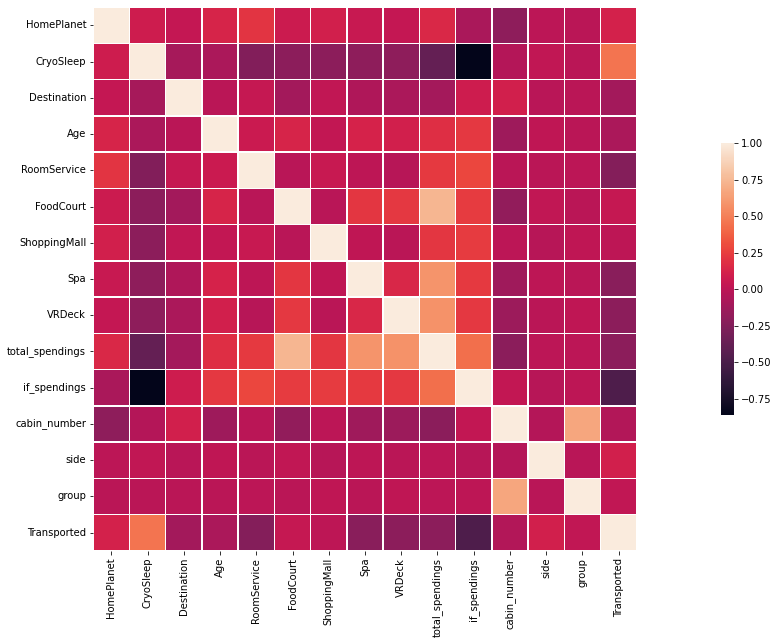

In [60]:
plt.figure(figsize=(30,10))
train_corr = train.copy()
train_corr = pd.concat([train_corr, labels], axis = 1)
corelationMatrix = train_corr.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corelationMatrix, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [61]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(train,labels)

In [62]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
featureScores = featureScores.sort_values(by=['Score'], ascending = False)
featureScores

,Feature,Score
9,total_spendings,1.886706e+06
7,Spa,1.691528e+06
8,VRDeck,1.536213e+06
4,RoomService,9.864773e+05
5,FoodCourt,1.024021e+05
11,cabin_number,7.365381e+03
13,group,6.181445e+03
6,ShoppingMall,1.792457e+03
1,CryoSleep,1.197498e+03
10,if_spendings,8.473718e+02


Text(0.5, 1.0, 'feature importance')

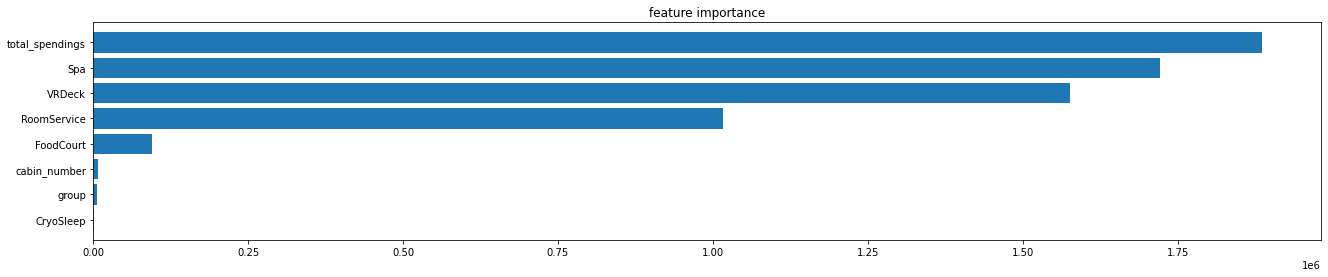

In [230]:
plt.figure(figsize=(22,4))
plt.barh(featureScores.Feature[0:8], featureScores.Score[0:8])
plt.gca().invert_yaxis()
plt.title('feature importance')

As we can see, the most important features are total_spendings, Spa, VRDeck, RooomService, FoodCourt, cabin_number, which is consistent with what we have seen from the plots above. 

Let's scale some of numerical continuous data to improve models performance.  

In [65]:
scaling_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'total_spendings']

In [67]:
scaler = StandardScaler()

scaler.fit(train[scaling_features])

train[scaling_features] = scaler.transform(train[scaling_features])
test[scaling_features] = scaler.transform(test[scaling_features])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [68]:
train

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total_spendings,if_spendings,cabin_number,side,group
0,1,0,2,0.711945,-0.340590,-0.287314,-0.290817,-0.276663,-0.269023,-0.514066,0,0.0,0,1
1,0,0,2,-0.334037,-0.175364,-0.281669,-0.248968,0.211505,-0.230194,-0.251479,1,0.0,1,2
2,1,0,2,2.036857,-0.275409,1.955616,-0.290817,5.694289,-0.225782,3.190333,1,0.0,1,3
3,1,0,2,0.293552,-0.340590,0.517406,0.330225,2.683471,-0.098708,1.332604,1,0.0,1,3
4,0,0,2,-0.891895,0.118709,-0.243409,-0.038048,0.225732,-0.267258,-0.124824,1,1.0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1,0,0,0.851410,-0.340590,3.989682,-0.290817,1.184286,-0.203720,2.531369,1,98.0,0,9276
8689,0,1,1,-0.752431,-0.340590,-0.287314,-0.290817,-0.276663,-0.269023,-0.514066,0,1499.0,1,9278
8690,0,0,2,-0.194573,-0.340590,-0.287314,2.842851,-0.275774,-0.269023,0.154175,1,1500.0,1,9279
8691,1,0,0,0.223820,-0.340590,0.370637,-0.290817,0.037223,2.585740,1.140302,1,608.0,1,9280


### Modeling and training

Some pre-training preperations.

In [63]:
def printScores(model, X, Y):
    # użyj classification_report() żeby policzyć najpopularniejsze miary 
    print("Classification report:")
    print(classification_report(Y, model.predict(X)))
    # wypisz macierz pomyłek 
    print("Confusion matrix:")
    print(confusion_matrix(Y, model.predict(X)))

In [69]:
x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size = 0.3, train_size = 0.7, random_state= 0)

To choose the final model, let's first perform a grid search for 6 popular ML models. 

In [85]:
classifiers = {
    "LogisticRegression" : LogisticRegression(solver='liblinear', random_state=0),
    "KNN" : KNeighborsClassifier(),
    "Tree" : DecisionTreeClassifier(random_state=0),
    "RandomForest" : RandomForestClassifier(random_state=0),
    "LGBM" : LGBMClassifier(random_state=0),
    "NaiveBayes": GaussianNB()
}

LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

T_grid = {'ccp_alpha': [0.01, 0.015, 0.02, 0.025, 0.03, 0.035]}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [100, 125, 150, 175, 200, 225, 250],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15, 0.2]}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "RandomForest" : RF_grid,
    "Tree" : T_grid,
    "LGBM" : boosted_grid,
    "CatBoost" : boosted_grid,
    "NaiveBayes": NB_grid
}

In [86]:
i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(x_train, y_train)
    valid_scores.iloc[i,1]=clf.score(x_test, y_test)

    # Save trained model
    clf_best_params[key]=clf.best_params_
    
    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1

Model: LogisticRegression
Training time (mins): 0.14

Model: KNN
Training time (mins): 0.03

Model: Tree
Training time (mins): 0.02

Model: RandomForest
Training time (mins): 1.78

Model: LGBM
Training time (mins): 2.36

Model: NaiveBayes
Training time (mins): 0.0



In [87]:
valid_scores

,Classifer,Validation accuracy,Training time
0,LogisticRegression,0.784893,0.14
1,KNN,0.574770,0.03
2,Tree,0.740414,0.02
3,RandomForest,0.789877,1.78
4,LGBM,0.804831,2.36
5,NaiveBayes,0.715107,0.00


We see that LGBM model perform  best, that's why we chose this model as the final one.

In [88]:
clf_best_params

{'LogisticRegression': {'C': 0.75, 'max_iter': 50, 'penalty': 'l1'},
 'KNN': {'n_neighbors': 9, 'p': 1},
 'Tree': {'ccp_alpha': 0.01},
 'RandomForest': {'max_depth': 10, 'n_estimators': 150},
 'LGBM': {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200},
 'NaiveBayes': {'var_smoothing': 1e-10}}

In [74]:
final_model = LGBMClassifier(random_state=0, learning_rate = 0.1, max_depth = 4, n_estimators = 200)

In [75]:
final_model.fit(train, labels)

LGBMClassifier(max_depth=4, n_estimators=200, random_state=0)

In [76]:
printScores(final_model, x_test, y_test)

Classification report:
              precision    recall  f1-score   support

       False       0.86      0.83      0.85      1303
        True       0.84      0.87      0.85      1305

    accuracy                           0.85      2608
   macro avg       0.85      0.85      0.85      2608
weighted avg       0.85      0.85      0.85      2608

Confusion matrix:
[[1087  216]
 [ 174 1131]]


### Submission

In [77]:
pred = final_model.predict_proba(test)[:,1]

In [78]:
pred

array([0.62135616, 0.03111117, 0.97394485, ..., 0.898312  , 0.76917072,
       0.68898997])

In [79]:
pred_class = np.where(pred > 0.5, True, False)

In [80]:
pred_class

array([ True, False,  True, ...,  True,  True,  True])

In [81]:
sub=pd.read_csv('sample_submission.csv')
sub['Transported'] = pred_class

In [82]:
sub

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [83]:
sub['Transported'].value_counts()

True     2199
False    2078
Name: Transported, dtype: int64

In [84]:
sub.to_csv('submission.csv', index=False)